## Inspecting the WheatFspm model

The goal of this notebook is to inspect the prediction targets and observable state available in the WheatFspm model.

As a dataset, the NEMA model is used from Barillot et al. 2016 (H0, H3, and H15).

### Loading the dataset

These datasets were collected and converted in the WheatFspm repository.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

In [2]:
DATASET_NEMA_H0 = '../datasets/dataset_NEMA_NEMA_H0.csv'
DATASET_NEMA_H3 = '../datasets/dataset_NEMA_NEMA_H3.csv'
DATASET_NEMA_H15 = '../datasets/dataset_NEMA_NEMA_H15.csv'

In [3]:
from src.model.rc_dataset import ExperimentDataset

dataset_nema_h0 = ExperimentDataset(csv_path=DATASET_NEMA_H0)
dataset_nema_h3 = ExperimentDataset(csv_path=DATASET_NEMA_H3)
dataset_nema_h15 = ExperimentDataset(csv_path=DATASET_NEMA_H15)

In [4]:
print(dataset_nema_h3)

Dataset properties:
	n_runs:       1
	n_steps:    1200
	state_size:  21

Available targets: 
	input_air_temperature, input_humidity, input_Wind, input_PARi, output__axes__C_exudated, output__axes__SAM_temperature, output__axes__Total_Transpiration, output__axes__delta_teq, output__axes__delta_teq_roots, output__axes__mstruct, output__axes__sum_TT, output__axes__sum_respi_roots, output__axes__sum_respi_shoot, output__axes__teq_since_primordium, output__soils__Conc_Nitrates_Soil, output__soils__Tsoil, output__soils__mineralisation, output__soils__nitrates, output__organ_grains__R_grain_growth_starch, output__organ_grains__R_grain_growth_struct, output__organ_grains__S_Proteins, output__organ_grains__S_grain_starch, output__organ_grains__S_grain_structure, output__organ_grains__age_from_flowering, output__organ_grains__proteins, output__organ_grains__starch, output__organ_grains__structure, output__organ_phloem__amino_acids, output__organ_phloem__sucrose, output__organ_roots__AA_consumpti

### Inspecting the targets

The targets can be classified as follows:

- Inputs (meteorological)
- Outputs (Computed aggregate plant fitness signals)
  - Axes
  - Soils
  - Organs

In [5]:
dataset = dataset_nema_h3
run_id = 'NEMA_H3'

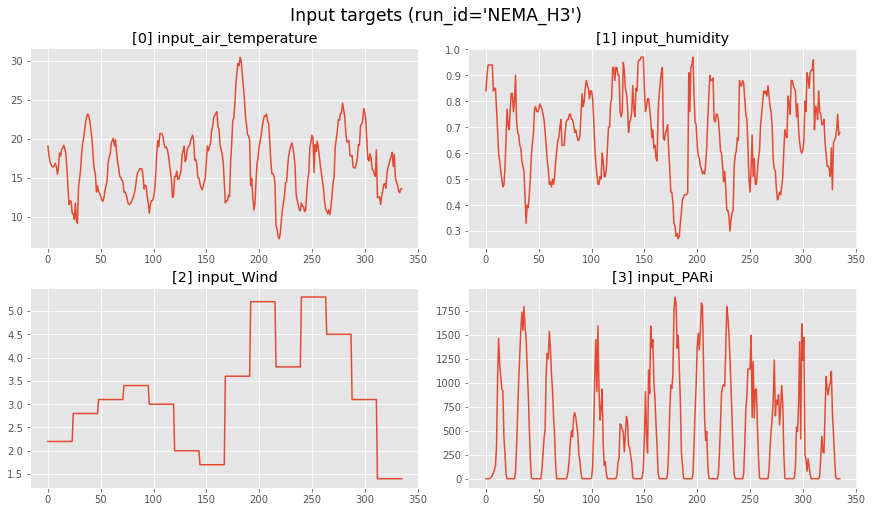

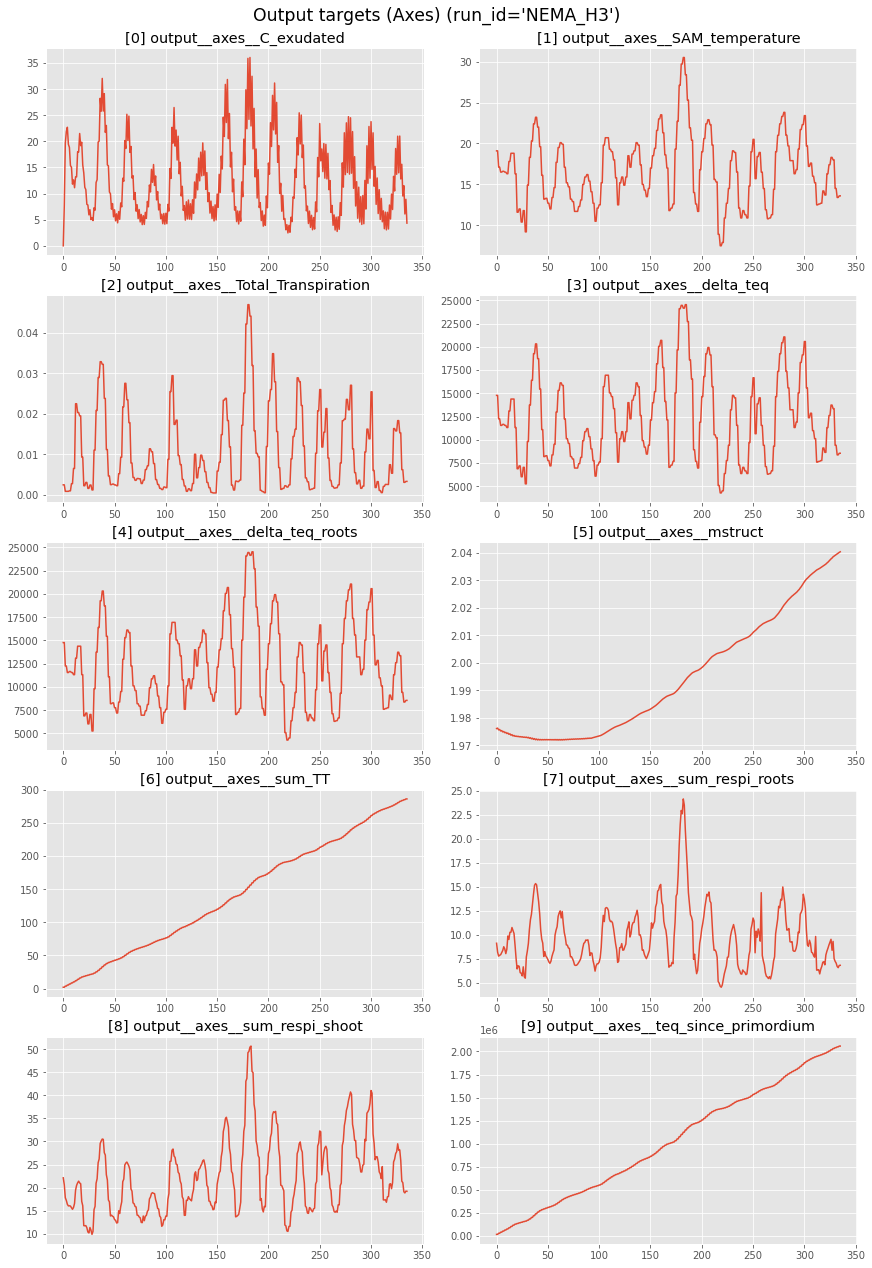

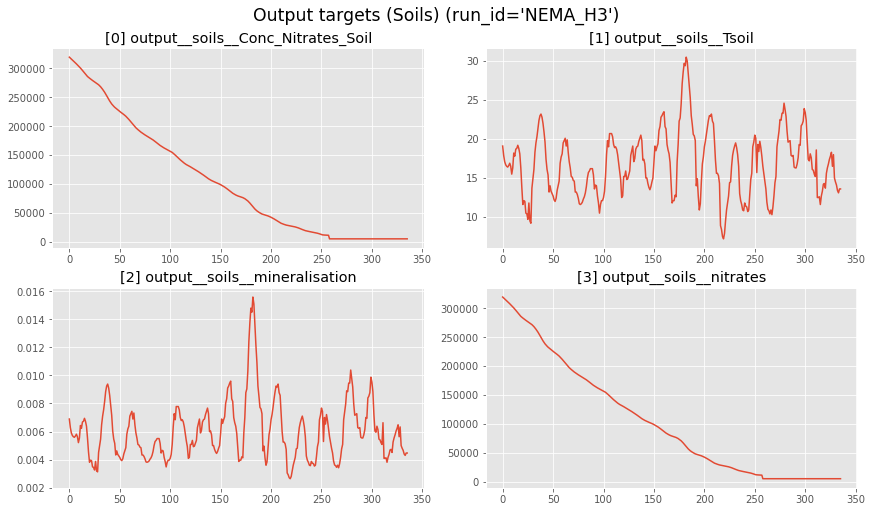

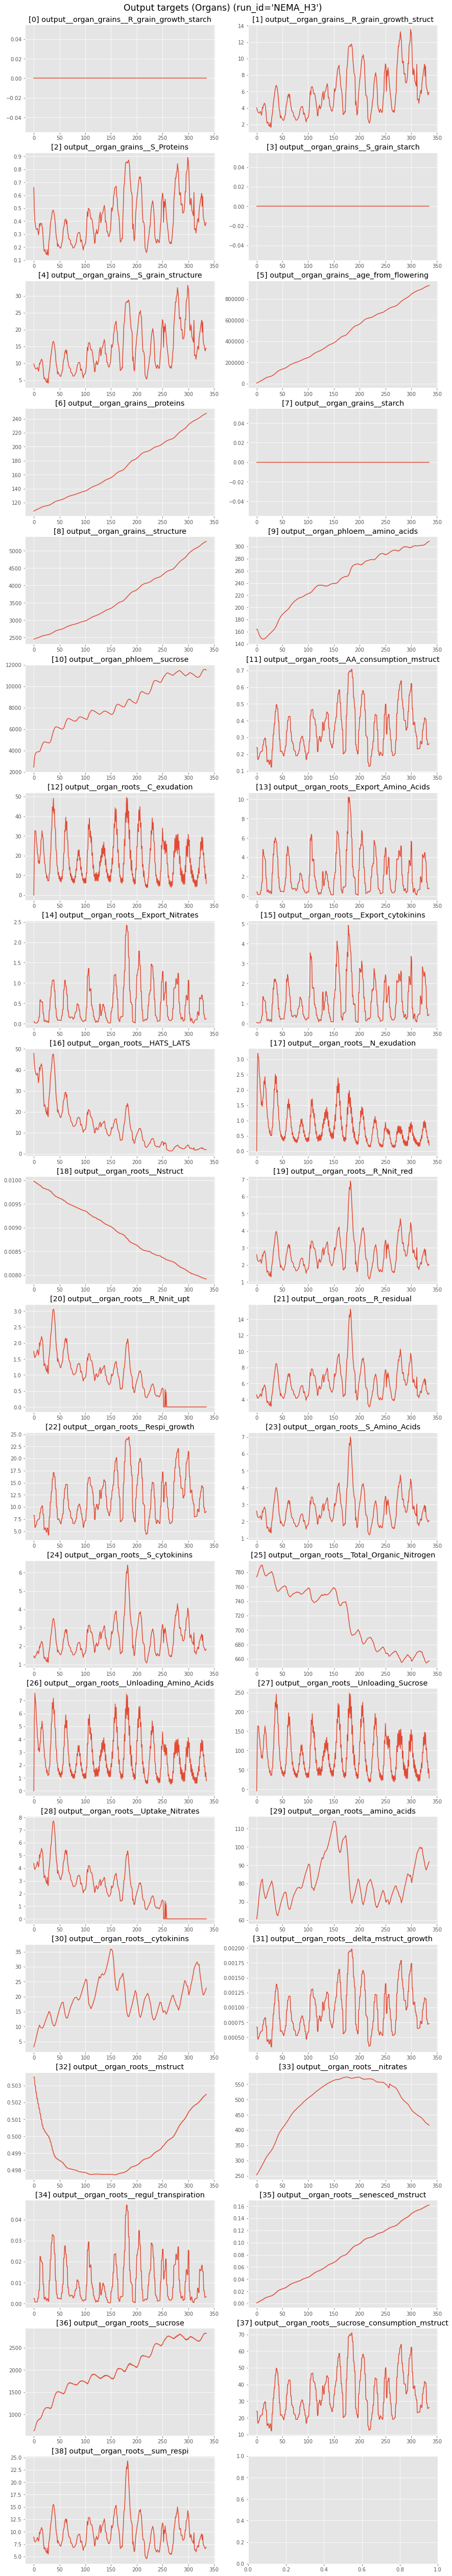

In [6]:
OFFSET = 0 * 24
MIN_T = OFFSET
MAX_T = MIN_T + 14 * 24

N_COLS = 2

targets = dataset.get_targets()

targets_input = [target for target in targets if target.startswith('input_')]
targets_axes = [target for target in targets if target.startswith('output__axes__')]
targets_soils = [target for target in targets if target.startswith('output__soils__')]
targets_organ = [target for target in targets if target.startswith('output__organ')]


target_class_names = ['Input targets', 'Output targets (Axes)', 'Output targets (Soils)', 'Output targets (Organs)']
target_classes = zip(target_class_names, [targets_input, targets_axes, targets_soils, targets_organ])

for class_name, targets in target_classes:
  with plt.style.context('ggplot'):
    n_rows = int(np.ceil(len(targets) / N_COLS))
    fig, ax = plt.subplots(n_rows, N_COLS, figsize=(12, 3.5 * n_rows), constrained_layout=True)

    for i, target in enumerate(targets):
      row, col = i // N_COLS, i % N_COLS

      data = dataset.get_target(target, run_id)
      data = data[MIN_T:MAX_T]

      ax[row, col].plot(data)
      ax[row, col].set_title(f'[{i}] {target}')

    fig.suptitle(f'{class_name} ({run_id=})', size='xx-large')
    plt.show()

##### Input temperature and output SAM temperature

It seems that the SAM_temperature and the input temperature are very tightly coupled. I cannot find the meaning of SAM temperature in the two source papers for the model however...

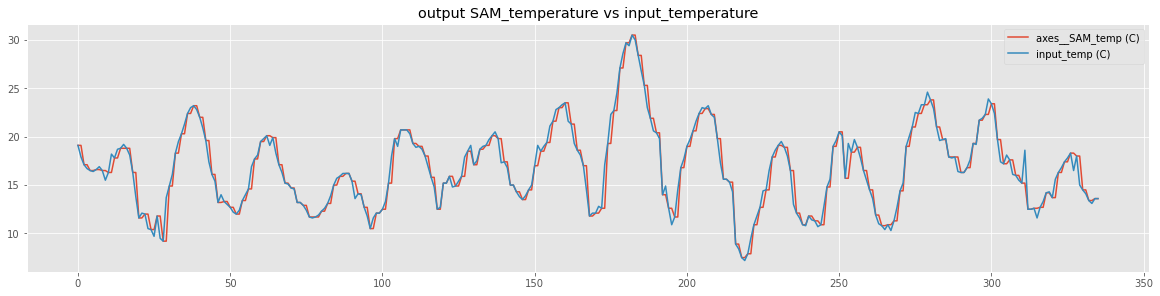

In [7]:
OFFSET = 0 * 24
MIN_T = OFFSET
MAX_T = MIN_T + 14 * 24


sam_temperature = dataset.get_target('output__axes__SAM_temperature', run_id)[MIN_T:MAX_T]
input_temperature = dataset.get_target('input_air_temperature', run_id)[MIN_T:MAX_T]

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 1, figsize=(16, 4), constrained_layout=True)

  ax.plot(sam_temperature, label="axes__SAM_temp (C)")
  ax.plot(input_temperature, label="input_temp (C)")

  ax.set_title('output SAM_temperature vs input_temperature')

  ax.legend()
  plt.show()

### Inspecting the state variables

BIG NOTE: not every observed node has a time series for every state variable (e.g. a leaf and a stem may have different sets of observable states!)

In [40]:
dataset = dataset_nema_h3
run_id = 'NEMA_H3'

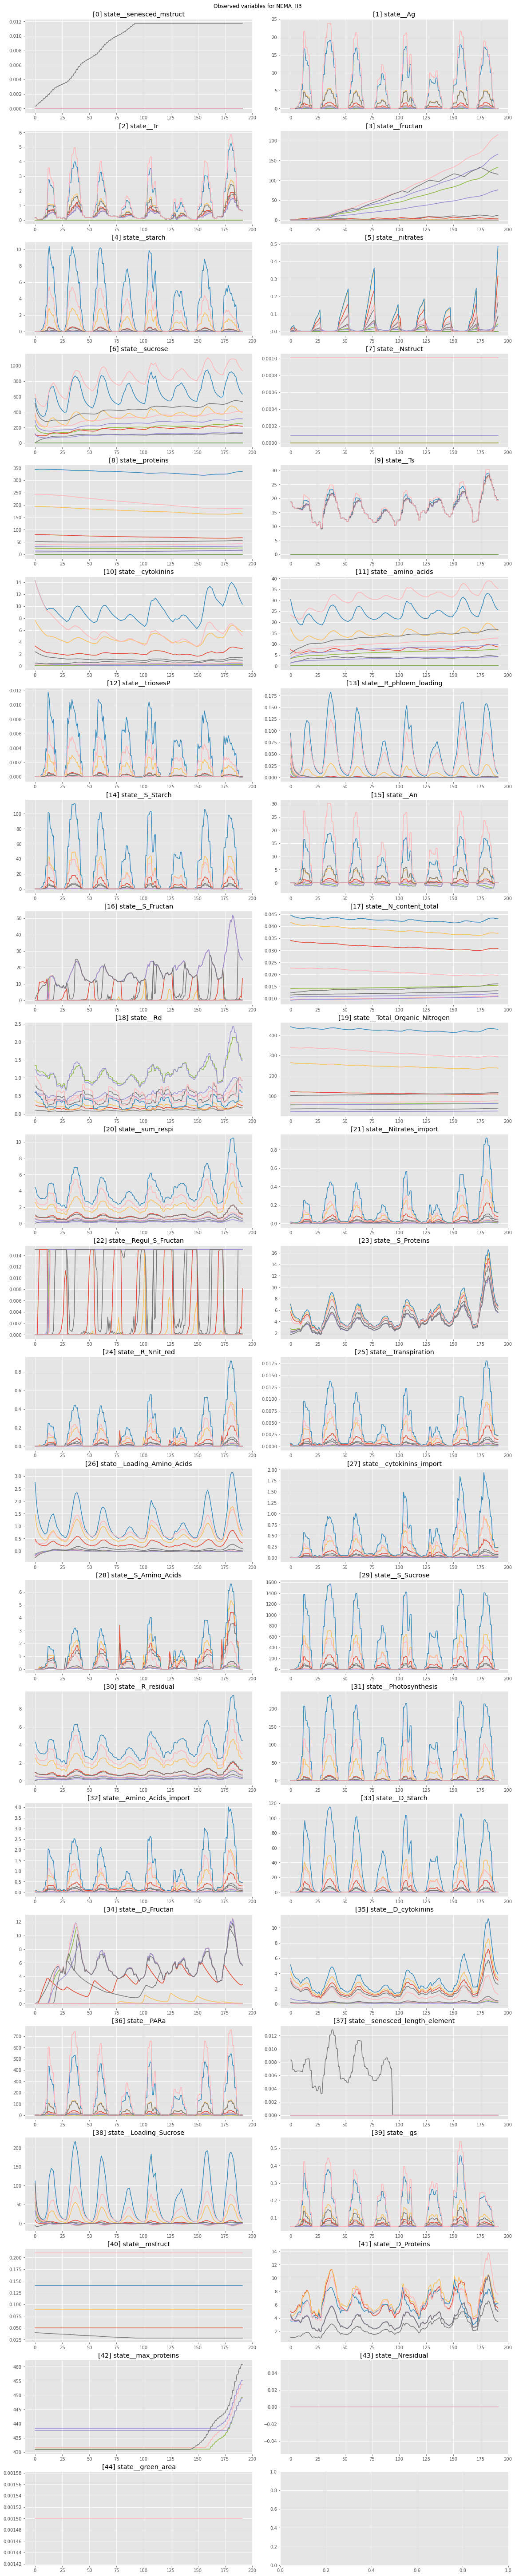

In [9]:
OFFSET = 0 * 24
MIN_T = OFFSET
MAX_T = MIN_T + 8 * 24

N_COLS = 2

state_vars = dataset.get_state_variables()

with plt.style.context('ggplot'):
  n_rows = int(np.ceil(len(state_vars) / N_COLS))
  fig, ax = plt.subplots(n_rows, N_COLS, figsize=(16, 3.5 * n_rows), constrained_layout=True)

  for i, state_var in enumerate(state_vars):
    row, col = i // N_COLS, i % N_COLS

    data = dataset.get_state(state_var, run_id)
    data = data[MIN_T:MAX_T]

    ax[row, col].plot(data)
    ax[row, col].set_title(f'[{i}] {state_var}')

  fig.suptitle(f'Observed variables for {run_id}')
  plt.show()

### Selection of targets and observed states

Selection is based on:

1. Overlap with HydroShoot model
2. Long-term / short-term memory requirements for prediction
3. Periodicity / information content over time

In [11]:
hydroshoot_inputs = (
    'input_air_temperature', 
    'input_humidity',
    'input_Wind',
    'input_PARi'
    )
hydroshoot_outputs = (
    'output__axes__Total_Transpiration',
     'output__axes__C_exudated', 
     'output__axes__SAM_temperature'
    )
hydroshoot_state = (
    'state__An',
    'state__Transpiration',
    'state__S_Sucrose',
    'state__Ts',
    'state__gs'
    )


In [12]:
exclusive_outputs = (
    'output__axes__delta_teq',
    'output__axes__sum_respi_shoot',
    'output__organ_roots__N_exudation'
)

exclusive_state = (
    'state__Ag',
    'state__Tr',
    'state__sucrose',
    'state__Rd',
    'state__sum_respi',
    'state__Photosynthesis',
    'state__PARa'
)

In [13]:
selected_inputs = [*hydroshoot_inputs]
selected_outputs = [*hydroshoot_outputs, *exclusive_outputs]
selected_state = [*hydroshoot_state, *exclusive_state]

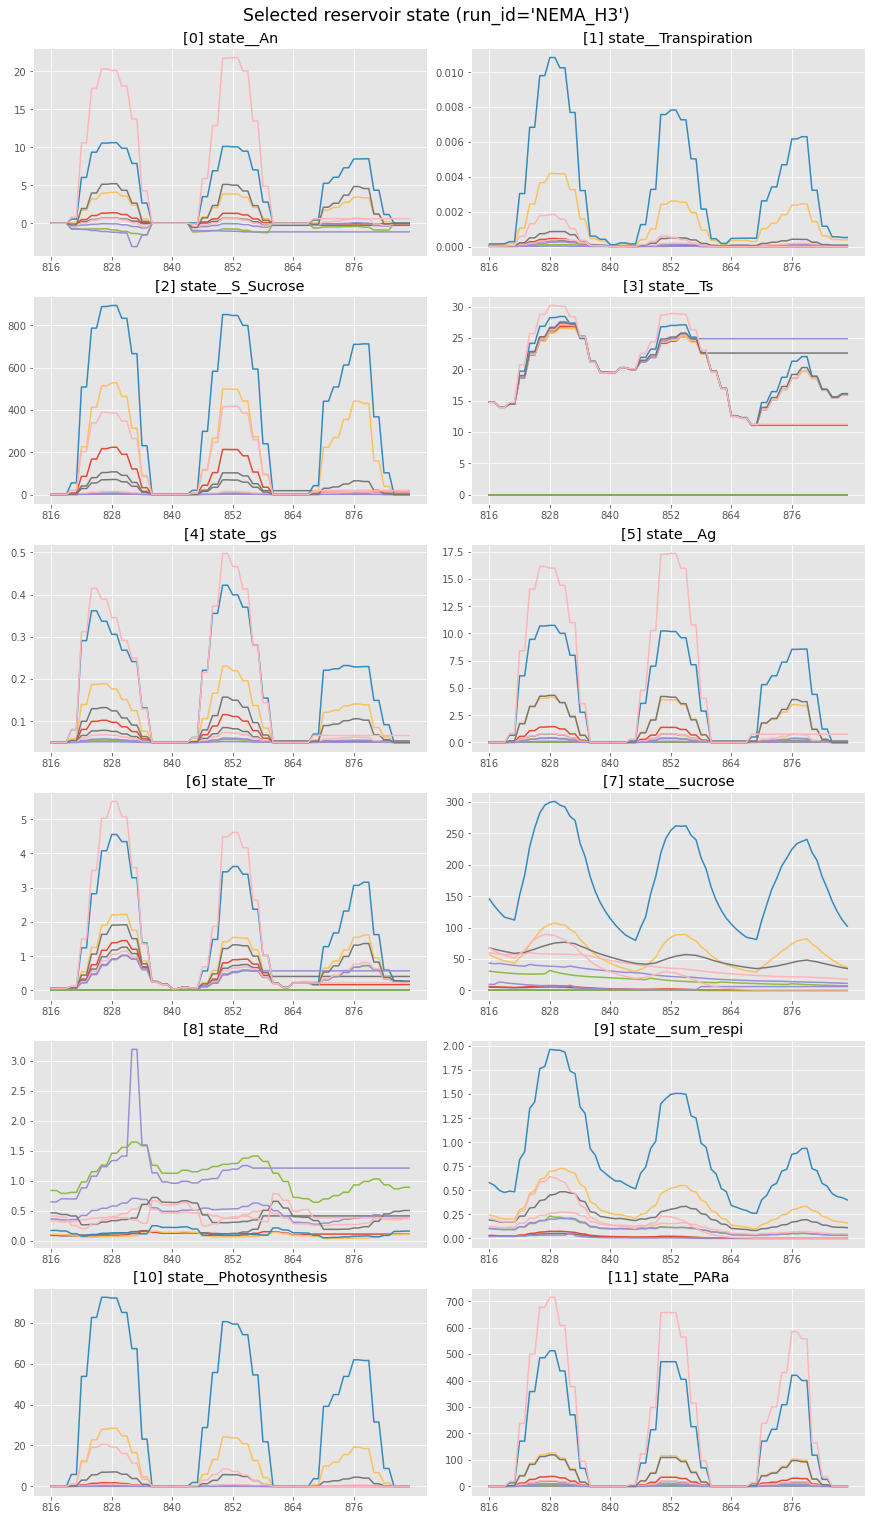

In [41]:
OFFSET = 500 + 10 * 24
MIN_T = 864 - 72 + 24 #OFFSET
MAX_T = 864 + 24 # MIN_T + 7 * 24

N_COLS = 2

# class_names = ['Selected inputs', 'Selected outputs', 'Selected reservoir state']
class_names = ['Selected reservoir state']
# classes = zip(class_names, [selected_inputs, selected_outputs, selected_state])
classes = zip(class_names, [selected_state])


for class_name, series_keys in classes:
  with plt.style.context('ggplot'):
    n_rows = int(np.ceil(len(series_keys) / N_COLS))
    fig, ax = plt.subplots(n_rows, N_COLS, figsize=(12, 3.5 * n_rows), constrained_layout=True, squeeze=False)

    for i, key in enumerate(series_keys):
        row, col = i // N_COLS, i % N_COLS
        
        if key.startswith('state__'):
            data = dataset.get_state(key, run_id)
        else:
            data = dataset.get_target(key, run_id)
        data = data[MIN_T:MAX_T]

        ax[row, col].plot(np.arange(MIN_T, MAX_T), data)
        ax[row, col].set_title(f'[{i}] {key}')
        ax[row, col].set_xticks(np.arange(MIN_T, MAX_T, 12))

    fig.suptitle(f'{class_name} ({run_id=})', size='xx-large')
    plt.show()

### Inspecting regime change in plant state (2022-03-25)

I noticed a clear regime change around step 850 for NEMA_H3. I think to err on the safe side I will not include anything past this point in the dataset because it will only worsen the score and we only want to study plants that are in pseudo-static state for now.

`state__An` seems to be a good indicator for detecting the mode switch.

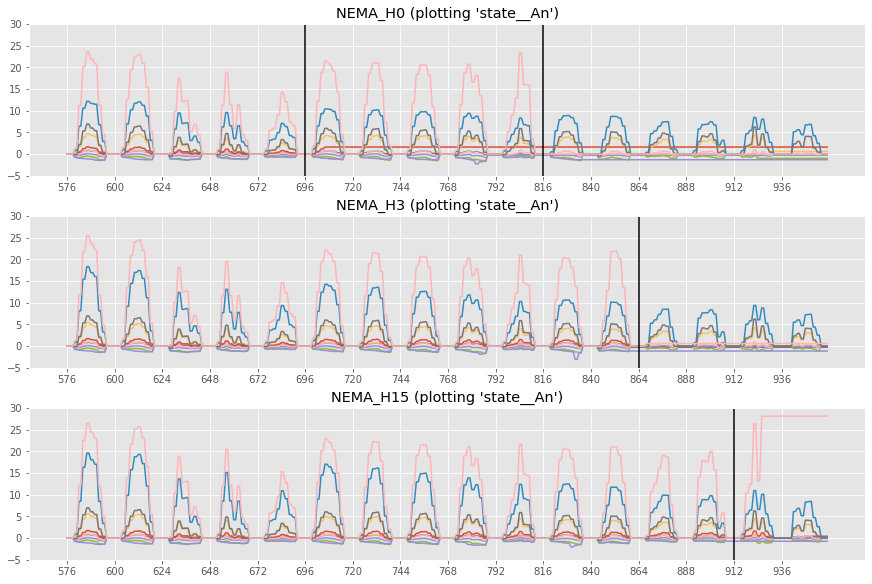

In [77]:
dataset_names = ['NEMA_H0', 'NEMA_H3', 'NEMA_H15']
datasets = (dataset_nema_h0, dataset_nema_h3, dataset_nema_h15)
state_var = 'state__An'
# bounds = (
#   (500, 800), 
#   (864 - 48, 864 + 48),
#   (0, 1000)
# )

bounds = (
  (792 - 9 * 24, 960),
  (792 - 9 * 24, 960),
  (792 - 9 * 24, 960),
)

boundary = ((696, 816), 864, 912)

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(3, 1, figsize=(12, 8), constrained_layout=True)
  
  for i, (_dataset, (min_t, max_t)) in enumerate(zip(datasets, bounds)):
    data = _dataset.get_state(state_var, dataset_names[i])
    data = data[min_t:max_t]

    ax[i].plot(np.arange(min_t, max_t), data)
    ax[i].vlines(boundary[i], -5, 30, color='black')
    ax[i].set_xticks(np.arange(min_t, max_t, 24))
    ax[i].set_ylim(-5, 30)
    ax[i].set_title(f'{dataset_names[i]} (plotting \'{state_var}\')')

  plt.show()  